# Prediction Pipeline: Tree-Based

In [1]:
from predictor import BasePredictor
from utils import Utils

config = Utils.read_config_for_env(config_path='../config/config.yml')
predictor = BasePredictor(
    config,
    refresh_monthly=False,
    refresh_ts_features=False,
    clean_strategy='olrem_for_all',
    # split_strategy='random',
    # split_strategy='last_months_val',
    split_strategy='months',
    num_lag_mon=3,
    val_ratio=0.2,
    scaler_type='standard')

Loading data.. Done.
Fixing data schemas.. Done.
Loading /home/onur/WORK/DS/repos/shop_sales_prediction/data/all_ts.parquet


In [3]:
# split the data and do the scaling:
# stores X_train, y_train, X_val, y_val and feature_names in predictor object
predictor.split_scale_X_y()

Scaling X train and X val with StandardScaler() scaler


## Basic LightGBM model

In [4]:
import lightgbm as lgb
# from lightgbm import LGBMRegressor 
import numpy as np
import shap
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

/home/onur/WORK/DS/repos/shop_sales_prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(
    predictor.X_train,
    label=predictor.y_train,
    feature_name=predictor.feature_names) 
# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
val_data = lgb.Dataset(
    predictor.X_val,
    label=predictor.y_val,
    feature_name=predictor.feature_names,
    reference=train_data) 
# Define a dictionary of parameters for configuring the LightGBM regression model. 

In [6]:
params = { 
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
}
callback_early_stopping = lgb.early_stopping(5)
num_round = 100
model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[val_data],
    callbacks=[callback_early_stopping, lgb.log_evaluation()],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.038061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 33255000, number of used features: 17
[LightGBM] [Info] Start training from score 0.073998
[1]	valid_0's rmse: 0.670359
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 0.644167
[3]	valid_0's rmse: 0.622298
[4]	valid_0's rmse: 0.60294
[5]	valid_0's rmse: 0.587582
[6]	valid_0's rmse: 0.574282
[7]	valid_0's rmse: 0.563091
[8]	valid_0's rmse: 0.553806
[9]	valid_0's rmse: 0.545834
[10]	valid_0's rmse: 0.539075
[11]	valid_0's rmse: 0.533221
[12]	valid_0's rmse: 0.52841
[13]	valid_0's rmse: 0.52452
[14]	valid_0's rmse: 0.520948
[15]	valid_0's rmse: 0.517952
[16]	valid_0's rmse: 0.515243
[17]	valid_0's rmse: 0.513195
[18]	valid_0's rmse: 0.511476
[19

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

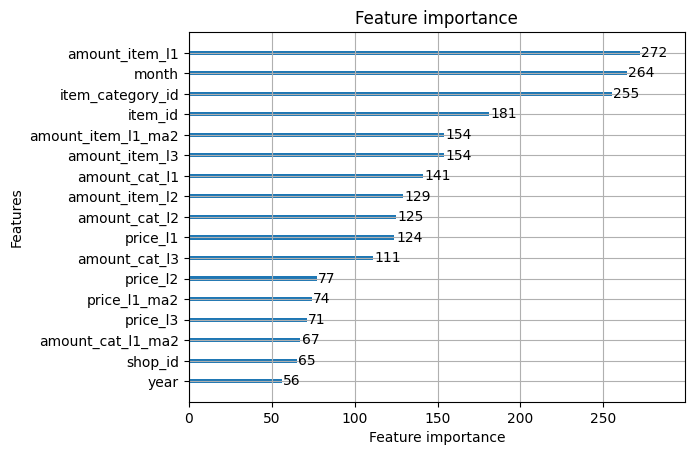

In [7]:
lgb.plot_importance(model)

In [8]:
# Make predictions on the training and validation data. 
pred_train = model.predict(predictor.X_train)
pred_val = model.predict(predictor.X_val)

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions. 
print("Training RMSE: ", np.sqrt(mse(predictor.y_train, pred_train)))
print("Validation RMSE: ", np.sqrt(mse(predictor.y_val, pred_val)))

Training RMSE:  0.5411535263153255
Validation RMSE:  0.49473595747152405


## LightGBM tuned with AutoML

In [9]:
from flaml import AutoML
import numpy as np
import matplotlib.pyplot as plt

In [10]:
automl = AutoML()
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": "mse",  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ["lgbm"],  # list of ML learners; we tune lightgbm in this example
    "task": "regression",  # task type
    "log_file_name": "store_sales_lgbm.log"  # flaml log file
    # "seed": 42,  # random seed
}
automl.fit(
    X_train=predictor.X_train,
    y_train=predictor.y_train,
    **settings)

[flaml.automl.logger: 06-08 14:09:03] {1680} INFO - task = regression
[flaml.automl.logger: 06-08 14:09:03] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-08 14:09:51] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 06-08 14:09:51] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 06-08 14:09:51] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-08 14:09:52] {2345} INFO - Estimated sufficient time budget=22283659s. Estimated necessary time budget=22284s.
[flaml.automl.logger: 06-08 14:09:52] {2392} INFO -  at 48.2s,	estimator lgbm's best error=0.6637,	best estimator lgbm's best error=0.6637
[flaml.automl.logger: 06-08 14:09:52] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-08 14:09:52] {2392} INFO -  at 48.8s,	estimator lgbm's best error=0.6637,	best estimator lgbm's best error=0.6637
[flaml.automl.logger: 06-08 14:09:52] {2219} INFO - iteration 2, current learner lgbm
[f

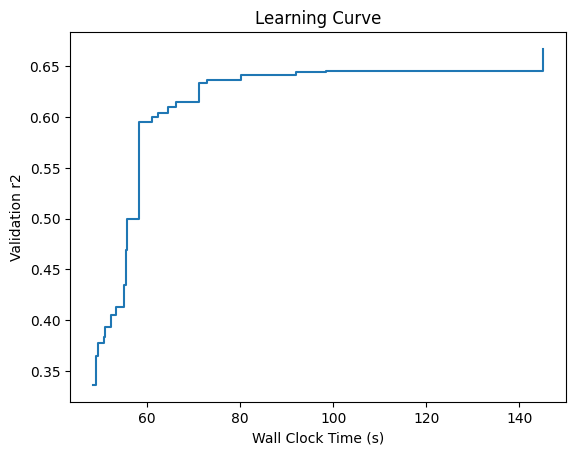

In [11]:
from flaml.automl.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=settings['log_file_name'], time_budget=600)
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [12]:
print("Best hyperparmeter config:", automl.best_config)
print("Best r2 on validation data: {0:.4g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 373, 'num_leaves': 139, 'min_child_samples': 22, 'learning_rate': 0.13082659451673045, 'log_max_bin': 7, 'colsample_bytree': 0.5405793904429114, 'reg_alpha': 0.0009765625, 'reg_lambda': 5.930706073365397}
Best r2 on validation data: 0.7238
Training duration of best run: 576 s
LGBMRegressor(colsample_bytree=0.5405793904429114,
              learning_rate=0.13082659451673045, max_bin=127,
              min_child_samples=22, n_estimators=1, n_jobs=-1, num_leaves=139,
              reg_alpha=0.0009765625, reg_lambda=5.930706073365397, verbose=-1)


In [13]:
# Make predictions on the training and validation data. 
pred_train = automl.predict(predictor.X_train)
pred_val = automl.predict(predictor.X_val)

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions. 
print("Training RMSE: ", np.sqrt(mse(predictor.y_train, pred_train)))
print("Validation RMSE: ", np.sqrt(mse(predictor.y_val, pred_val)))

Training RMSE:  0.46661718071227887
Validation RMSE:  0.4917596716657752


<BarContainer object of 17 artists>

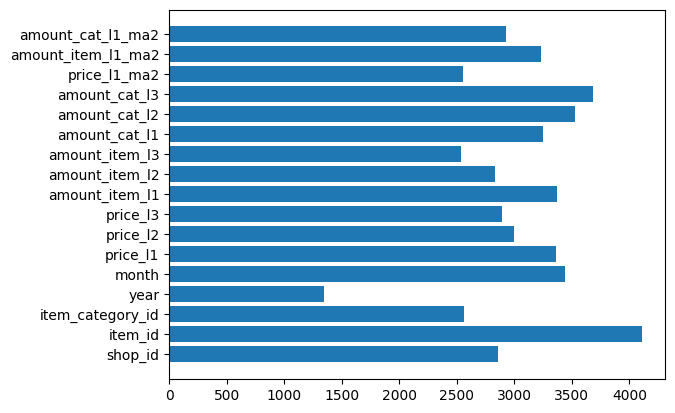

In [14]:
# plt.barh(automl.feature_names_in_, automl.feature_importances_)
plt.barh(predictor.feature_names, automl.feature_importances_)

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
X = np.arange(20).reshape((5, 4))
X.shape
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)